In [1]:
# install dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.11.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
# install dependency for AdamW optimizer
!pip install -q tf-models-official==2.11.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.2 requires cupy-cuda115, which is not installed.
distributed 2021.11.2 requires dask==2021.11.2, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.12.2 requires dask<=2021.11.2,>=2021.11.1, but you have dask 2022.2.0 which is incompatible.


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization  # to create AdamW optimizer

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

In [4]:
TRAIN_DIR = "/kaggle/input/nlp-getting-started/train.csv"
TEST_DIR = "/kaggle/input/nlp-getting-started/test.csv"

train = pd.read_csv(TRAIN_DIR)
test = pd.read_csv(TEST_DIR)

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
seed = 42

train_shuffle = train.sample(frac=1, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(train_shuffle.text, 
                                                  train_shuffle.target, 
                                                  test_size=0.2, 
                                                  random_state=seed)
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes = 2)

In [7]:
prefetch_buffer = tf.data.AUTOTUNE
batch_size = 32


train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)\
                                                                .cache()\
                                                                .prefetch(buffer_size=prefetch_buffer)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)\
                                                           .cache()\
                                                           .prefetch(buffer_size=prefetch_buffer)

In [8]:
# create bert proprocessor and bert encoder from tfhub
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

bert_preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
bert_encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

In [9]:
# build custom model by linking preprocessor output to encoder and adding a dorpout and a final dense layer
def build_classifier_model(preprocessor, encoder):    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

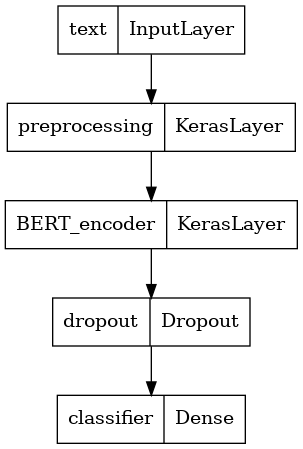

In [10]:
classifier_model = build_classifier_model(bert_preprocessor, bert_encoder)

tf.keras.utils.plot_model(classifier_model)

In [11]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy()

metrics = tf.keras.metrics.CategoricalAccuracy()

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [13]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
191/191 [==============================] - 56s 242ms/step - loss: 0.5545 - categorical_accuracy: 0.7227 - val_loss: 0.4280 - val_categorical_accuracy: 0.8096
Epoch 2/5
191/191 [==============================] - 46s 239ms/step - loss: 0.3826 - categorical_accuracy: 0.8353 - val_loss: 0.4350 - val_categorical_accuracy: 0.8188
Epoch 3/5
191/191 [==============================] - 47s 244ms/step - loss: 0.3185 - categorical_accuracy: 0.8672 - val_loss: 0.4810 - val_categorical_accuracy: 0.8175
Epoch 4/5
191/191 [==============================] - 46s 244ms/step - loss: 0.2625 - categorical_accuracy: 0.8946 - val_loss: 0.4873 - val_categorical_accuracy: 0.8201
Epoch 5/5
191/191 [==============================] - 47s 245ms/step - loss: 0.2292 - categorical_accuracy: 0.9122 - val_loss: 0.5118 - val_categorical_accuracy: 0.8221


In [14]:
test_ds = tf.data.Dataset.from_tensor_slices((test.text)).batch(batch_size)\
                                                         .cache()\
                                                         .prefetch(buffer_size=prefetch_buffer)

In [15]:
testing_labels = classifier_model.predict(test_ds)
print(testing_labels)

102/102 [==============================] - 11s 104ms/step
[[0.5471179  0.45288217]
 [0.01155794 0.988442  ]
 [0.01222073 0.9877793 ]
 ...
 [0.01511258 0.9848874 ]
 [0.02069002 0.97931004]
 [0.10687242 0.89312756]]


In [16]:
import numpy as np

test = pd.read_csv(TEST_DIR)

#turn categorical results into 0/1
test_labels = np.argmax(testing_labels, axis=1)

#adding the 'target' column for prediction results
test['target'] = test_labels

In [17]:
# check some disaster tweet predictions
test[test.target == 1]

,id,keyword,location,text,target
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [18]:
# check some non-disaster tweet predictions
test[test.target == 0]

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
5,12,NaN,NaN,We're shaking...It's an earthquake,0
6,21,NaN,NaN,They'd probably still show more life than Arse...,0
7,22,NaN,NaN,Hey! How are you?,0
8,27,NaN,NaN,What a nice hat?,0
...,...,...,...,...,...
3247,10806,wrecked,Seattle Washington,RT CNBC '3 words from Disney CEO Bob Iger wrec...,0
3248,10807,wrecked,Acey mountain islanddåÇTorontoåÈ,Smackdown tyme this should put me in a good mo...,0
3249,10816,wrecked,los angeles,@thrillhho jsyk I haven't stopped thinking abt...,0
3250,10820,wrecked,"Brussels, Belgium",@stighefootball Begovic has been garbage. He g...,0


In [19]:
# generate submission results 
submission = test[['id','target']]
submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [20]:
submission.to_csv('submission.csv', index = False)